In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.impute import SimpleImputer



In [2]:
# --- 1. Montar Drive y Definir Rutas ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

BASE_DIR = "/content/drive/My Drive/AI Projects/Customer Churn/"
DATA_DIR = BASE_DIR + "datasets/"

# --- 2. Cargar el Dataset Final (listo para el modelo) ---
print("Cargando dataset 'model_input.parquet'...")
try:
    df_model_input = pd.read_parquet(DATA_DIR + "model_input.parquet")
    print("✅ ¡Dataset cargado exitosamente!")
    display(df_model_input.head())

except FileNotFoundError:
    print("❌ Error: No se encontró 'model_input.parquet'.")
    print("Por favor, ejecuta el Notebook 03 y asegúrate de guardar el archivo.")

print("\nTipos de datos (dtypes):")
print(df_model_input.info())

Cargando dataset 'model_input.parquet'...
✅ ¡Dataset cargado exitosamente!


,recency,frequency,monetary,tenure_days,avg_payment_value,avg_items_per_order,avg_freight_value,n_unique_categories,main_category,churn
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,112,141.90,1.0,12.00,1,bed_bath_table,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,115,27.19,1.0,8.29,1,health_beauty,0
0000f46a3911fa3c0805444483337064,537,1,86.22,537,86.22,1.0,17.22,1,stationery,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,321,43.62,1.0,17.63,1,telephony,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,288,196.89,1.0,16.89,1,telephony,1



Tipos de datos (dtypes):
<class 'pandas.core.frame.DataFrame'>
Index: 93358 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   recency              93358 non-null  int64  
 1   frequency            93358 non-null  int64  
 2   monetary             93358 non-null  float64
 3   tenure_days          93358 non-null  int64  
 4   avg_payment_value    93357 non-null  float64
 5   avg_items_per_order  93358 non-null  float64
 6   avg_freight_value    93358 non-null  float64
 7   n_unique_categories  93358 non-null  int64  
 8   main_category        93358 non-null  object 
 9   churn                93358 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 7.8+ MB
None


# Paso 1: Preprocesamiento y División de Datos
Nuestros datos no están listos para el modelo. Debemos hacer dos cosas:

Separar las features (X) de la variable objetivo (y).

Procesar las features:

Las columnas numéricas (recency, monetary, etc.) deben ser escaladas (para que tengan un rango similar).

La columna categórica (main_category) debe ser convertida a números usando One-Hot Encoding.

Usaremos un ColumnTransformer para hacer esto de forma limpia y profesional.

In [4]:


# --- 1. Separar Features (X) y Target (y) ---
y = df_model_input['churn']
X = df_model_input.drop('churn', axis=1)


# --- 2. Identificar tipos de columnas ---
# --- LÍNEA CORREGIDA ---
numerical_features = [
    # 'recency',
    'frequency', 'monetary',
    # 'tenure_days',
    'avg_payment_value', 'avg_items_per_order',
    'avg_freight_value', 'n_unique_categories'
]
categorical_features = ['main_category']

print(f"Features numéricas: {numerical_features}")
print(f"Features categóricas: {categorical_features}")


# --- 3. Crear el Pipeline de Preprocesamiento (CORREGIDO) ---

# Pipeline para datos numéricos
# AHORA tiene 2 pasos: Imputar (rellenar NaNs) y Escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para datos categóricos
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Unir ambos pipelines en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # <-- ¡AQUÍ ESTÁ EL CAMBIO! (de 'passthrough' a 'drop')
)


# --- 4. Dividir en Train y Test ---
# (Esta parte no cambia)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nForma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Features numéricas: ['frequency', 'monetary', 'avg_payment_value', 'avg_items_per_order', 'avg_freight_value', 'n_unique_categories']
Features categóricas: ['main_category']

Forma de X_train: (74686, 9)
Forma de X_test: (18672, 9)


# Paso 2: Construir el Pipeline del Modelo
Ahora, creamos un Pipeline completo que primero aplica nuestro preprocessor (Paso 1) y segundo aplica el modelo de machine learning (ej. Regresión Logística).

Esto evita el "data leakage" (fuga de datos) y simplifica todo el proceso.

In [5]:

# --- Modelo 1: Regresión Logística (Baseline) ---
# Es un modelo simple, rápido y bueno para empezar

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)) # 'class_weight' ayuda con el desbalanceo
])


# --- Modelo 2: Random Forest (Más Potente) ---
# Un modelo basado en árboles, muy robusto y que suele dar mejores resultados

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced')) # 'class_weight' ayuda
])

# Lista de modelos para iterar
models = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf
}

# Paso 3: Entrenar y Evaluar los Modelos
Este es el momento de la verdad. Entrenamos cada modelo con los datos de _train y evaluamos su rendimiento con los datos de _test.

--- Entrenando: Logistic Regression ---

Evaluación en el conjunto de Test:
**AUC-ROC Score: 0.6058**

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      7621
           1       0.66      0.63      0.64     11051

    accuracy                           0.59     18672
   macro avg       0.58      0.58      0.58     18672
weighted avg       0.59      0.59      0.59     18672


Matriz de Confusión:


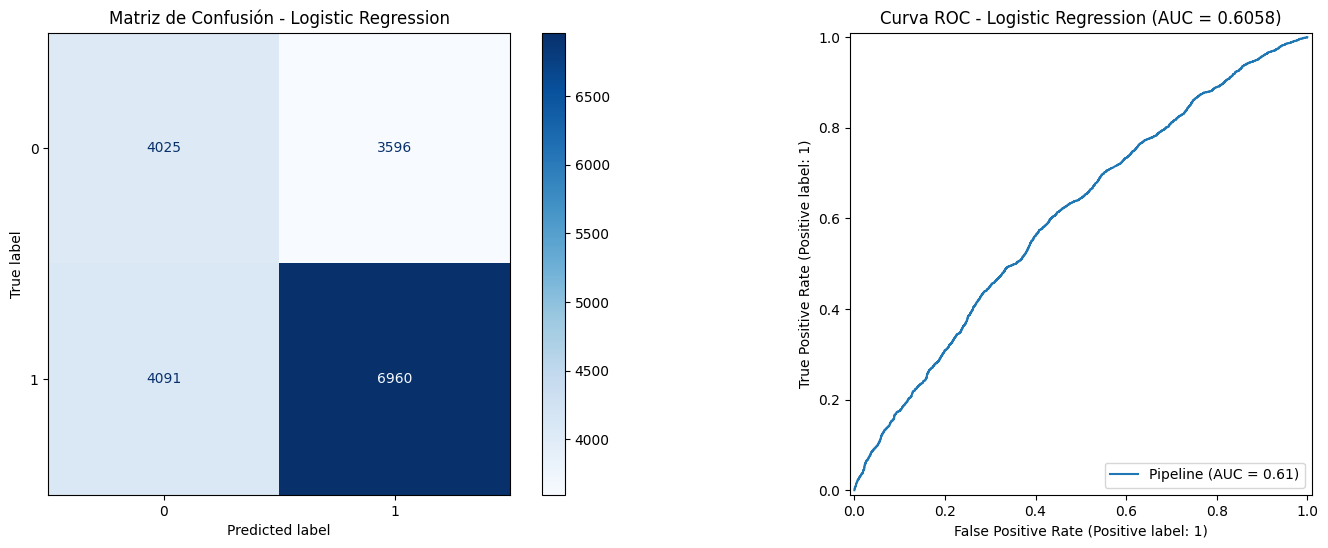

------------------------------------------------------------
--- Entrenando: Random Forest ---

Evaluación en el conjunto de Test:
**AUC-ROC Score: 0.9214**

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      7621
           1       0.85      0.88      0.87     11051

    accuracy                           0.84     18672
   macro avg       0.83      0.83      0.83     18672
weighted avg       0.84      0.84      0.84     18672


Matriz de Confusión:


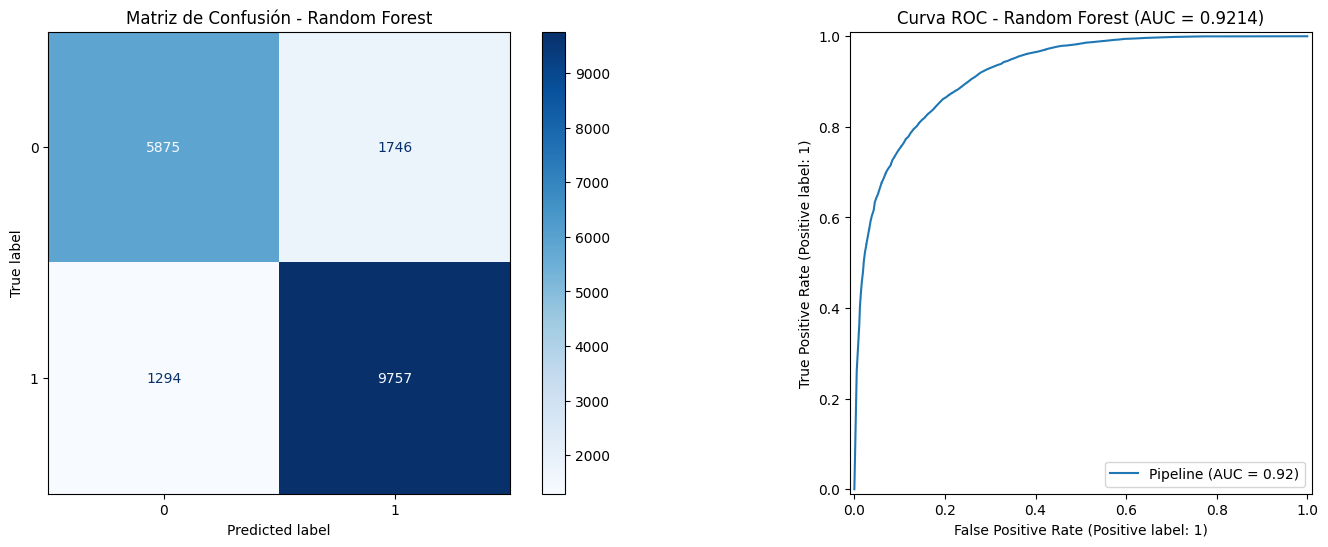

------------------------------------------------------------


In [6]:
# --- 3. Entrenar y Evaluar ---

for name, model in models.items():
    print(f"--- Entrenando: {name} ---")

    # 1. Entrenar el modelo
    model.fit(X_train, y_train)

    # 2. Hacer predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidad de 'churn' (clase 1)

    print("\nEvaluación en el conjunto de Test:")

    # 3. Métrica clave: AUC-ROC
    # Es la mejor métrica para problemas de churn (desbalanceados)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"**AUC-ROC Score: {auc:.4f}**")

    # 4. Reporte de Clasificación (Precision, Recall, F1)
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # 5. Matriz de Confusión
    print("\nMatriz de Confusión:")
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico de la Matriz de Confusión
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                          cmap=plt.cm.Blues,
                                          ax=ax[0])
    ax[0].set_title(f"Matriz de Confusión - {name}")

    # Gráfico de la Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=ax[1])
    ax[1].set_title(f"Curva ROC - {name} (AUC = {auc:.4f})")

    plt.show()
    print("-" * 60)

# Paso 5: Interpretación (¿Por qué abandonan?)
Usaremos una técnica llamada "Importancia de las Features" (Feature Importance). Le pediremos a nuestro pipeline_rf (que ya está entrenado) que nos diga en qué features se fijó más para tomar sus decisiones.

--- Interpretando el Modelo Ganador (Random Forest) ---


/tmp/ipython-input-1845472865.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_agg.values, y=importances_agg.index, palette='viridis')


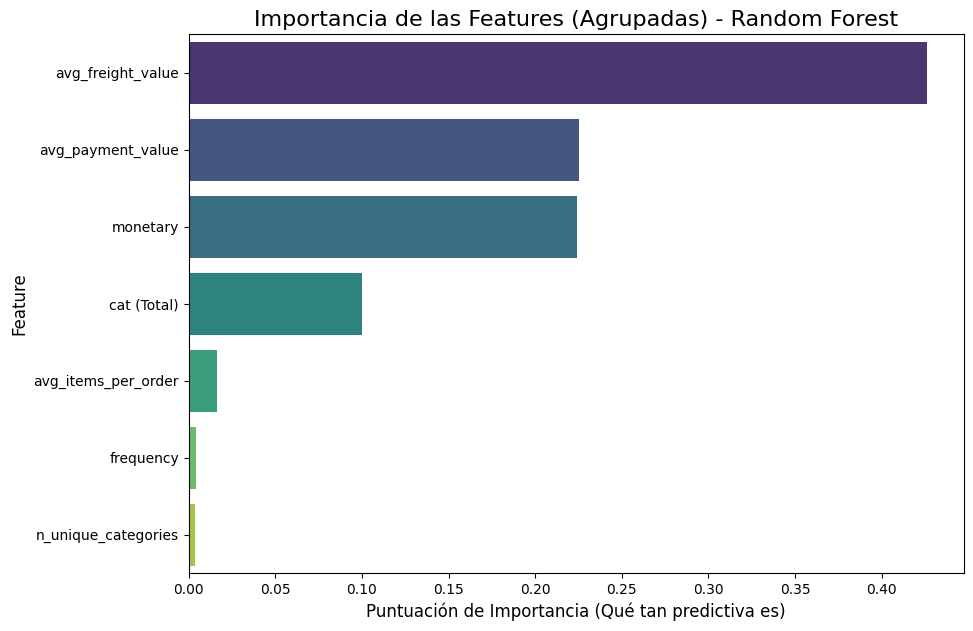


--- Features más importantes para predecir el Churn ---
avg_freight_value      0.426101
avg_payment_value      0.225218
monetary               0.224226
cat (Total)            0.099807
avg_items_per_order    0.016509
frequency              0.004441
n_unique_categories    0.003698
dtype: float64


In [7]:
# --- Paso 5: Interpretación del Modelo (Importancia de Features) ---

print("--- Interpretando el Modelo Ganador (Random Forest) ---")

# 1. Acceder al pipeline del Random Forest que ya entrenamos
# Usamos 'models["Random Forest"]' para obtener el pipeline de la celda anterior
rf_pipeline = models["Random Forest"]

# 2. Acceder a los componentes del pipeline por su nombre
preprocessor = rf_pipeline.named_steps['preprocessor']
model = rf_pipeline.named_steps['classifier']

# 3. Obtener los nombres de las features después de ser transformadas
# (Esto nos da nombres como 'num__frequency', 'cat__main_category_auto', etc.)
try:
    feature_names_out = preprocessor.get_feature_names_out()
except Exception as e:
    print(f"Error obteniendo nombres: {e}")
    print("Asegúrate de tener scikit-learn v1.0 o superior.")
    # Fallback para versiones antiguas (menos limpio)
    # feature_names_out = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())


# 4. Obtener las puntuaciones de importancia del modelo
importances = model.feature_importances_

# 5. --- Agregación Inteligente de Importancias ---
# No queremos ver 70 categorías, queremos agruparlas.
# Vamos a sumar la importancia de todas las 'cat__main_category_...' en una sola.

feature_groups = {}
for name, importance in zip(feature_names_out, importances):
    if name.startswith('num__'):
        # Es una feature numérica, usamos su nombre limpio
        clean_name = name.replace('num__', '')
        feature_groups[clean_name] = feature_groups.get(clean_name, 0) + importance

    elif name.startswith('cat__'):
        # Es una feature categórica, la agrupamos
        # Ej: 'cat__main_category_auto' -> 'main_category (Total)'
        clean_name = name.split('_')[0].replace('cat__', '') + " (Total)"
        feature_groups[clean_name] = feature_groups.get(clean_name, 0) + importance

# 6. Convertir el diccionario agrupado en una Serie de Pandas
importances_agg = pd.Series(feature_groups).sort_values(ascending=False)

# 7. --- Graficar las importancias ---
plt.figure(figsize=(10, 7))
sns.barplot(x=importances_agg.values, y=importances_agg.index, palette='viridis')
plt.title('Importancia de las Features (Agrupadas) - Random Forest', fontsize=16)
plt.xlabel('Puntuación de Importancia (Qué tan predictiva es)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# 8. Mostrar los resultados
print("\n--- Features más importantes para predecir el Churn ---")
print(importances_agg)

# Paso 6: Verificación de la Hipótesis ("¿Por qué el envío?")
Crearemos dos gráficos para investigar esto.

Gráfico de Cajas (Box Plot): Para una vista estadística rápida.

Gráfico de Tasa de Abandono (Bar Plot): Para una vista de negocio clara.

Usaremos el DataFrame df_model_input, que ya tiene todas las columnas (avg_freight_value y churn) que necesitamos.

--- Verificando la Hipótesis: Costo de Envío vs. Abandono ---


/tmp/ipython-input-2471670025.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


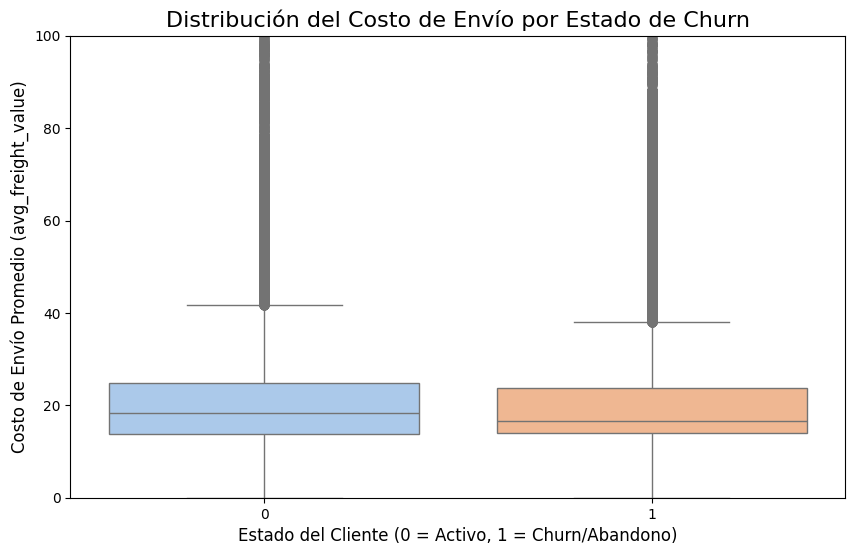

/tmp/ipython-input-2471670025.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_freight = df_plot.groupby('freight_bin')['churn'].mean().reset_index()
/tmp/ipython-input-2471670025.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


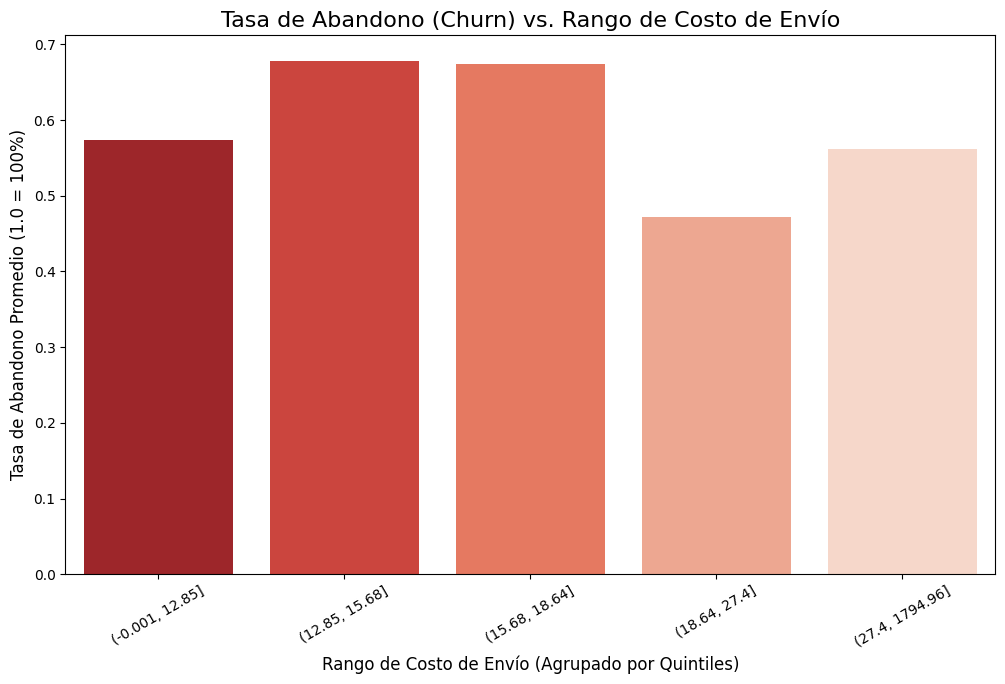


--- Tasa de Abandono (Churn) por Rango de Costo de Envío ---
       freight_bin     churn
0  (-0.001, 12.85]  0.573383
1   (12.85, 15.68]  0.677970
2   (15.68, 18.64]  0.674054
3    (18.64, 27.4]  0.472057
4  (27.4, 1794.96]  0.561770


In [8]:
# --- Paso 6: Verificar la Hipótesis del Costo de Envío ---
# (Asegúrate de que df_model_input está cargado en memoria)

print("--- Verificando la Hipótesis: Costo de Envío vs. Abandono ---")

# --- Gráfico 1: Comparación de Distribución (Box Plot) ---
# ¿Cómo se distribuye el costo de envío para los que abandonan vs. los que no?

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_model_input,
    x='churn',
    y='avg_freight_value',
    palette='pastel'
)
# Limitamos el eje Y para evitar que outliers (envíos de 500€) distorsionen el gráfico
plt.ylim(0, 100)
plt.title('Distribución del Costo de Envío por Estado de Churn', fontsize=16)
plt.xlabel('Estado del Cliente (0 = Activo, 1 = Churn/Abandono)', fontsize=12)
plt.ylabel('Costo de Envío Promedio (avg_freight_value)', fontsize=12)
plt.show()


# --- Gráfico 2: Tasa de Abandono por Rango de Envío (Gráfico de Negocio) ---
# "Si el envío cuesta más, ¿la gente abandona más?"

# 1. Crear 'bins' (rangos) para el costo de envío.
#    Usamos pd.qcut para crear 5 grupos (quintiles) con el mismo número de clientes
df_plot = df_model_input.copy()
try:
    df_plot['freight_bin'] = pd.qcut(df_plot['avg_freight_value'], q=5, duplicates='drop')
except ValueError:
    # Si 'qcut' falla (por muchos valores idénticos), usamos 'cut'
    df_plot['freight_bin'] = pd.cut(df_plot['avg_freight_value'], bins=5)


# 2. Calcular la tasa media de 'churn' (abandono) para cada rango
churn_rate_by_freight = df_plot.groupby('freight_bin')['churn'].mean().reset_index()

# 3. Graficar los resultados
plt.figure(figsize=(12, 7))
sns.barplot(
    data=churn_rate_by_freight,
    x='freight_bin',
    y='churn',
    palette='Reds_r' # Paleta de rojo
)
plt.title('Tasa de Abandono (Churn) vs. Rango de Costo de Envío', fontsize=16)
plt.xlabel('Rango de Costo de Envío (Agrupado por Quintiles)', fontsize=12)
plt.ylabel('Tasa de Abandono Promedio (1.0 = 100%)', fontsize=12)
plt.xticks(rotation=30) # Rotar las etiquetas para que se lean mejor
plt.show()

print("\n--- Tasa de Abandono (Churn) por Rango de Costo de Envío ---")
print(churn_rate_by_freight)

# Paso 7: Guardar el Modelo para Despliegue
Añade esta celda al final de tu Notebook 04. Usaremos joblib porque es más eficiente para modelos de scikit-learn que contienen grandes arrays de NumPy.

In [9]:
import joblib

# --- Paso 7: Guardar el Modelo para Despliegue ---

# Selecciona tu modelo ganador (el pipeline completo)
final_model = models["Random Forest"]

# Define la ruta de guardado
model_path = DATA_DIR + "rf_churn_model.joblib"

# Guarda el modelo
joblib.dump(final_model, model_path)

print(f"¡Modelo guardado exitosamente en: {model_path}!")

¡Modelo guardado exitosamente en: /content/drive/My Drive/AI Projects/Customer Churn/datasets/rf_churn_model.joblib!


# Paso 2: Crear el Script de la API (main.py)
Esta es la parte más importante. En un proyecto real, crearías un nuevo archivo .py. En Colab, podemos "escribir" este archivo mágicamente en una celda

In [10]:
# Instalar FastAPI y el servidor (uvicorn)
!pip install fastapi uvicorn python-multipart

In [11]:
%%writefile main.py
import pandas as pd
import joblib
from fastapi import FastAPI
from pydantic import BaseModel

# --- 1. Definir la Aplicación ---
# "app" es el nombre estándar de la instancia de FastAPI
app = FastAPI(title="API de Predicción de Churn", version="1.0")


# --- 2. Cargar el Modelo ---
# Esta es la ruta DONDE VIVIRÁ el modelo en nuestro servidor
# (Ajusta la ruta si es necesario, pero esta debería funcionar en Colab)
MODEL_PATH = "/content/drive/My Drive/AI Projects/Customer Churn/datasets/rf_churn_model.joblib"
model = joblib.load(MODEL_PATH)


# --- 3. Definir el "Schema" de Entrada (¡Muy Importante!) ---
# Pydantic valida que los datos que recibimos son correctos.
# Deben coincidir con las features que usaste para entrenar.
class CustomerFeatures(BaseModel):
    frequency: int
    monetary: float
    avg_payment_value: float
    avg_items_per_order: float
    avg_freight_value: float
    n_unique_categories: int
    main_category: str

    # Ejemplo de cómo se verían los datos de entrada
    class Config:
        json_schema_extra = {
            "example": {
                "frequency": 1,
                "monetary": 59.90,
                "avg_payment_value": 59.90,
                "avg_items_per_order": 1.0,
                "avg_freight_value": 15.50,
                "n_unique_categories": 1,
                "main_category": "sports_leisure"
            }
        }


# --- 4. Crear el "Endpoint" de Predicción ---

@app.post("/predict")
def predict_churn(features: CustomerFeatures):

    # 1. Convertir los datos de entrada de Pydantic a un DataFrame
    # El pipeline de Scikit-learn espera un DataFrame de Pandas
    input_data = pd.DataFrame([features.model_dump()])

    # 2. Hacer la predicción de PROBABILIDAD
    # Usamos predict_proba() para obtener la confianza del modelo
    # El resultado es un array: [[prob_clase_0, prob_clase_1]]
    try:
        pred_proba = model.predict_proba(input_data)
    except Exception as e:
        return {"error": str(e)}

    # 3. Extraer la probabilidad de churn (Clase 1)
    churn_probability = pred_proba[0][1]

    # 4. Devolver el resultado
    return {
        "churn_probability": round(churn_probability, 4),
        "prediction": "Churn" if churn_probability > 0.5 else "Active"
    }

# --- 5. (Opcional) Endpoint Raíz ---
@app.get("/")
def read_root():
    return {"message": "Bienvenido a la API de Predicción de Churn. Usa el endpoint /docs para ver la documentación."}

Writing main.py


# Paso 3: Ejecutar y Probar la API (en Colab)
Colab no es un servidor, pero podemos simular uno usando uvicorn y ngrok (para exponerlo a internet).

Ejecuta esta celda para iniciar el servidor:

In [12]:
# Instalar la librería que falta
!pip install pyngrok

In [13]:
# Este comando guarda tu token en la configuración de ngrok
!ngrok config add-authtoken 34zALVEzofBFDOPoCgiEk3Llkhj_3WNBuzbfpP8K9cQ3CeyWB

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [14]:
import uvicorn
import threading
from pyngrok import ngrok, conf

# --- 1. Iniciar el servidor Uvicorn en un hilo separado ---
def run_app():
    uvicorn.run('main:app', host='127.0.0.1', port=8000)

print("Iniciando servidor Uvicorn en segundo plano...")
thread = threading.Thread(target=run_app)
thread.start()

# --- 2. Exponer el puerto 8000 a internet usando ngrok ---
# (Necesitarás una cuenta gratuita de ngrok y un Authtoken si da error)
# https://dashboard.ngrok.com/get-started/your-authtoken
try:
    public_url = ngrok.connect(8000)
    print(f"API corriendo en (haz clic aquí): {public_url}")
    print("Añade '/docs' al final de la URL para ver la documentación interactiva de FastAPI.")
except Exception as e:
    print(f"Error con ngrok: {e}")
    print("Es posible que necesites añadir tu Authtoken de ngrok.com:")
    print("!ngrok config add-authtoken 34zALVEzofBFDOPoCgiEk3Llkhj_3WNBuzbfpP8K9cQ3CeyWB")

Iniciando servidor Uvicorn en segundo plano...
API corriendo en (haz clic aquí): NgrokTunnel: "https://bulllike-mortifyingly-bristol.ngrok-free.dev" -> "http://localhost:8000"
Añade '/docs' al final de la URL para ver la documentación interactiva de FastAPI.


# Paso 4: ¡Llama a tu API!
Abre la Documentación: Haz clic en la URL ...ngrok-free.app que apareció. Añade /docs al final (ej. https://xyz.ngrok-free.app/docs).

Verás la documentación de tu API. Haz clic en el endpoint /predict, luego en "Try it out".

Haz una Predicción: Rellena el JSON de ejemplo y haz clic en "Execute".

O

In [16]:
import requests

# Reemplaza esta URL por la URL de ngrok que te dio la celda anterior
API_URL = "https://bulllike-mortifyingly-bristol.ngrok-free.dev"

# 1. Datos de un cliente (ejemplo)
test_customer = {
    "frequency": 1,
    "monetary": 59.90,
    "avg_payment_value": 59.90,
    "avg_items_per_order": 1.0,
    "avg_freight_value": 15.50, # <-- Envío en la "Zona de Peligro"
    "n_unique_categories": 1,
    "main_category": "sports_leisure"
}

# 2. Llamar al endpoint /predict
response = requests.post(f"{API_URL}/predict", json=test_customer)

# 3. Imprimir el resultado
print(f"Llamando a: {API_URL}/predict")
print("\nRespuesta de la API:")
print(response.json())

INFO:     34.86.70.182:0 - "POST /predict HTTP/1.1" 200 OK
Llamando a: https://bulllike-mortifyingly-bristol.ngrok-free.dev/predict

Respuesta de la API:
{'churn_probability': 0.42, 'prediction': 'Active'}
